<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/NY_LabelingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow

This colab aims in labeling the NY data for super spread week, safe week and improvement week as per the 'number of cases' increasing or decreasing every week.

Idea: 
* compute 7 -day moving average
* 14 days data compare with next 14 days rolling window
* split the % as buckets 
* label the data as per bucket

In [624]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [625]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

In [626]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')


In [627]:
!ls  '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'

CA_Covid-19.csv
CA-CovidAug22.csv
Maryland_University_SocialDistancing_Data
mask_rule.csv
mask_rule_data.csv
Newyork_combinedAug22.csv
Newyork_combined.csv
Newyork_combinedSep24.csv
NY_Covid-19.csv
NY-CovidAug21.csv
NY-CovidAug22.csv
NY_labeledData_Aug23.csv
NY_labeledData_Aug27.csv
NY_labeledData_Sep13.csv
NY_sd_inertia_labeledData_Aug27.csv
NY_sd_inertia_labeledData_Sep13.csv
NY_socialDistancingInertiaDataAug25.csv
NY_socialDistancingInertiaDataSep24.csv
queens_all_combined.csv
queens_all_filtered.csv
Queens_county.csv
Social_Distancing_Inertia_County.csv


# 1.1 Loading NY data

In [628]:
NY_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Newyork_combinedSep24.csv',low_memory=False)
NY_combined_data.head()

,Date,fips_x,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases
0,2020-03-01,36001,Albany County,305506,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0
1,2020-03-02,36001,Albany County,305506,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0
2,2020-03-03,36001,Albany County,305506,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.0,0
3,2020-03-04,36001,Albany County,305506,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.0,0
4,2020-03-05,36001,Albany County,305506,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.0,0


## Computing rolling average

In [629]:
NY_combined_data.iloc[:,16]

0       0
1       0
2       0
3       0
4       0
       ..
9799    0
9800    0
9801    0
9802    0
9803    0
Name: New cases, Length: 9804, dtype: int64

In [630]:
df = pd.DataFrame(columns=['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','rolling_avg_new_cases'])


In [631]:
NY_counties = NY_combined_data['County Name'].unique()

for county in NY_counties:
  county_data = NY_combined_data[NY_combined_data['County Name'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,16].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,NaN,305506.0
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0,NaN,305506.0
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.0,0,NaN,305506.0
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.0,0,NaN,305506.0
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.0,0,NaN,305506.0


In [632]:
print(df.shape)
NY_combined_data.shape

(9804, 18)


(9804, 17)

In [633]:
NY_combined_data = df.copy()
NY_combined_data

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.000,0,NaN,305506.0
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.000,0,NaN,305506.0
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.000,0,NaN,305506.0
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.000,0,NaN,305506.0
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.000,0,NaN,305506.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9799,2020-08-17,36123,Yates County,0.0,0.0,0.0,0.0,-23.0,0.0,281.57,4.181,60,73.676584,1,0.884,0,0.285714,24913.0
9800,2020-08-18,36123,Yates County,0.0,0.0,0.0,0.0,-23.0,0.0,276.14,3.576,51,73.676584,1,0.884,0,0.285714,24913.0
9801,2020-08-19,36123,Yates County,0.0,0.0,0.0,0.0,-22.0,0.0,350.22,6.347,91,73.676584,1,0.884,0,0.285714,24913.0
9802,2020-08-20,36123,Yates County,0.0,0.0,0.0,0.0,-21.0,0.0,320.75,6.822,98,73.676584,1,0.884,0,0.142857,24913.0


In [634]:
NY_combined_data[NY_combined_data['Date'] == '2020-08-01']

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
151,2020-08-01,36001,Albany County,-33.0,-10.0,0.0,-27.0,-14.0,1.0,35.56,2.260,47,584.364958,1,0.788,12,11.000000,305506.0
323,2020-08-01,36003,Allegany County,-6.0,14.0,0.0,0.0,-12.0,0.0,138.45,5.929,105,44.778541,1,0.771,0,0.000000,46091.0
495,2020-08-01,36007,Broome County,-21.0,-4.0,0.0,1.0,-14.0,1.0,91.40,2.238,49,269.900959,1,0.812,11,11.714286,190488.0
667,2020-08-01,36009,Cattaraugus County,-13.0,51.0,0.0,0.0,-13.0,0.0,146.27,4.348,79,58.177858,1,0.793,0,1.142857,76117.0
839,2020-08-01,36011,Cayuga County,-6.0,8.0,0.0,55.0,-7.0,-1.0,156.89,3.552,85,110.726163,1,0.732,1,0.714286,76576.0
1011,2020-08-01,36013,Chautauqua County,-5.0,20.0,0.0,0.0,-13.0,0.0,156.76,2.867,73,119.693840,1,0.703,3,2.142857,126903.0
1183,2020-08-01,36015,Chemung County,-21.0,0.0,0.0,-67.0,-2.0,-1.0,95.11,3.664,62,204.875414,1,0.594,0,0.428571,83456.0
1355,2020-08-01,36017,Chenango County,-8.0,30.0,0.0,0.0,-5.0,0.0,137.06,5.034,65,52.830843,1,0.735,2,0.857143,47207.0
1527,2020-08-01,36019,Clinton County,-19.0,4.0,0.0,-35.0,-10.0,-2.0,103.60,2.287,61,77.549742,1,0.773,1,1.142857,80485.0
1699,2020-08-01,36021,Columbia County,-10.0,3.0,0.0,24.0,-10.0,0.0,154.44,3.446,37,93.682154,1,0.848,3,2.714286,59461.0


In [635]:
NY_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,NaN,305506.0
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0,NaN,305506.0
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.0,0,NaN,305506.0
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.0,0,NaN,305506.0
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.0,0,NaN,305506.0
5,2020-03-06,36001,Albany County,6.0,10.0,12.0,7.0,3.0,0.0,37.03,5.428,113,584.364958,0,0.0,0,NaN,305506.0
6,2020-03-07,36001,Albany County,12.0,12.0,78.0,11.0,6.0,-1.0,21.45,3.992,83,584.364958,0,0.0,0,0.0,305506.0
7,2020-03-08,36001,Albany County,9.0,13.0,186.0,7.0,2.0,-1.0,-6.01,2.550,53,584.364958,0,0.0,0,0.0,305506.0


## clean data - fill NA 

In [636]:
NY_combined_data = NY_combined_data.fillna(0)
NY_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0,305506.0
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0,0.0,305506.0
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.0,0,0.0,305506.0
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.0,0,0.0,305506.0
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.0,0,0.0,305506.0
5,2020-03-06,36001,Albany County,6.0,10.0,12.0,7.0,3.0,0.0,37.03,5.428,113,584.364958,0,0.0,0,0.0,305506.0
6,2020-03-07,36001,Albany County,12.0,12.0,78.0,11.0,6.0,-1.0,21.45,3.992,83,584.364958,0,0.0,0,0.0,305506.0
7,2020-03-08,36001,Albany County,9.0,13.0,186.0,7.0,2.0,-1.0,-6.01,2.550,53,584.364958,0,0.0,0,0.0,305506.0


In [637]:
NY_combined_data['County Name'].unique()

array(['Albany County', 'Allegany County', 'Broome County',
       'Cattaraugus County', 'Cayuga County', 'Chautauqua County',
       'Chemung County', 'Chenango County', 'Clinton County',
       'Columbia County', 'Cortland County', 'Delaware County',
       'Dutchess County', 'Erie County', 'Essex County',
       'Franklin County', 'Fulton County', 'Genesee County',
       'Greene County', 'Herkimer County', 'Jefferson County',
       'Lewis County', 'Livingston County', 'Madison County',
       'Monroe County', 'Montgomery County', 'Nassau County',
       'New York County', 'Niagara County', 'Oneida County',
       'Onondaga County', 'Ontario County', 'Orange County',
       'Orleans County', 'Oswego County', 'Otsego County',
       'Putnam County', 'Rensselaer County', 'Rockland County',
       'St. Lawrence County', 'Saratoga County', 'Schenectady County',
       'Schoharie County', 'Schuyler County', 'Seneca County',
       'Steuben County', 'Suffolk County', 'Sullivan County',
 

## verifying Rolling average with visualizations

In [638]:
albany_county = NY_combined_data[NY_combined_data['County Name'] == 'Albany County']
print(albany_county.shape)
albany_county.head()

(172, 18)


,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0,305506.0
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0,0.0,305506.0
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.0,0,0.0,305506.0
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.0,0,0.0,305506.0
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.0,0,0.0,305506.0


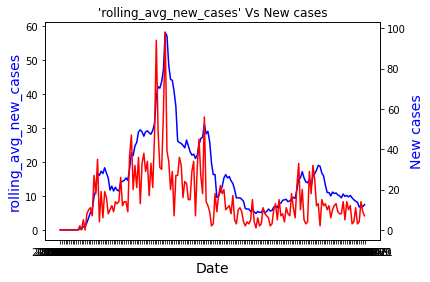

In [639]:
fig,ax = plt.subplots()
# make a plot
ax.plot(albany_county.Date, albany_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(albany_county.Date, albany_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

In [640]:
suffolk_county = NY_combined_data[NY_combined_data['County Name'] == 'Suffolk County']

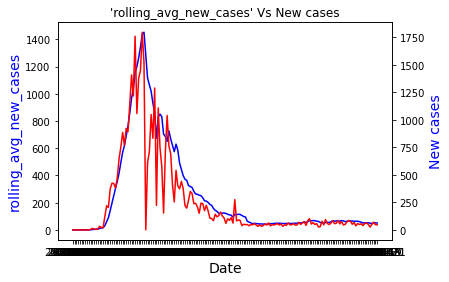

In [641]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## Rolling window to compare every 2 weeks with next 2 weeks

In [642]:
NY_combined_data = NY_combined_data.sort_values(by=['Date'])
NY_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0,305506.0
9632,2020-03-01,36123,Yates County,31.0,33.0,0.0,0.0,7.0,0.0,28.14,5.004,72,73.676584,0,0.0,0,0.0,24913.0
1548,2020-03-01,36021,Columbia County,21.0,4.0,0.0,25.0,4.0,0.0,19.75,5.337,58,93.682154,0,0.0,0,0.0,59461.0
7224,2020-03-01,36095,Schoharie County,26.0,9.0,0.0,0.0,13.0,0.0,24.47,2.137,27,49.852047,0,0.0,0,0.0,30999.0
2580,2020-03-01,36033,Franklin County,28.0,27.0,0.0,0.0,7.0,0.0,10.82,2.205,56,30.704920,0,0.0,0,0.0,50022.0


In [643]:
NY_combined_data[NY_combined_data['fips_x'] == 36001]

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.000,0,0.000000,305506.0
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.000,0,0.000000,305506.0
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.000,0,0.000000,305506.0
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.000,0,0.000000,305506.0
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.000,0,0.000000,305506.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,2020-08-17,36001,Albany County,0.0,0.0,0.0,0.0,-45.0,12.0,37.64,2.712,56,584.364958,1,0.788,3,8.142857,305506.0
168,2020-08-18,36001,Albany County,0.0,0.0,0.0,0.0,-43.0,12.0,44.94,3.480,72,584.364958,1,0.788,4,6.714286,305506.0
169,2020-08-19,36001,Albany County,0.0,0.0,0.0,0.0,-44.0,12.0,53.30,3.112,65,584.364958,1,0.788,14,7.285714,305506.0
170,2020-08-20,36001,Albany County,0.0,0.0,0.0,0.0,-43.0,11.0,58.89,3.448,72,584.364958,1,0.788,9,6.857143,305506.0


In [644]:
minDate = NY_combined_data['Date'].min()
print(minDate)

dateList = NY_combined_data['Date'].unique()

2020-03-01


In [645]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

0


In [646]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)
  


[1, '2020-03-01', '2020-03-14']
[2, '2020-03-15', '2020-03-28']
[3, '2020-03-29', '2020-04-11']
[4, '2020-04-12', '2020-04-26']
[5, '2020-04-27', '2020-05-10']
[6, '2020-05-11', '2020-05-24']
[7, '2020-05-25', '2020-06-08']
[8, '2020-06-09', '2020-06-22']
[9, '2020-06-23', '2020-07-06']
[10, '2020-07-07', '2020-07-20']
[11, '2020-07-21', '2020-08-03']
[12, '2020-08-04', '2020-08-17']
[13, '2020-08-18', '2020-08-21']


In [647]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head(2)

,WeekNumber,startDate,endDate
0,1,2020-03-01,2020-03-14
1,2,2020-03-15,2020-03-28


## Slice data for the week dataframe

In [648]:

average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (NY_combined_data['Date'] >= startDate) & (NY_combined_data['Date'] <= endDate)
    df_weekData =  NY_combined_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['County Name','fips_x'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)


In [649]:
average_newCases_df.shape

(741, 5)

In [650]:
average_newCases_df[average_newCases_df['fips_x'] == 36001]

,County Name,fips_x,average_per_week,startDate,endDate
0,Albany County,36001,0.112245,2020-03-01,2020-03-14
0,Albany County,36001,11.122449,2020-03-15,2020-03-28
0,Albany County,36001,14.785714,2020-03-29,2020-04-11
0,Albany County,36001,30.132653,2020-04-12,2020-04-26
0,Albany County,36001,40.244898,2020-04-27,2020-05-10
0,Albany County,36001,25.234694,2020-05-11,2020-05-24
0,Albany County,36001,15.183673,2020-05-25,2020-06-08
0,Albany County,36001,7.367347,2020-06-09,2020-06-22
0,Albany County,36001,6.336735,2020-06-23,2020-07-06
0,Albany County,36001,11.795918,2020-07-07,2020-07-20


## Verifying average per week data Eg., albany County

In [651]:
albany_county[(albany_county['Date'] >= '2020-03-01') & (albany_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']



0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.285714
12    0.285714
13    1.000000
Name: rolling_avg_new_cases, dtype: float64

In [652]:
average_newCases_df.head(10)

,County Name,fips_x,average_per_week,startDate,endDate
0,Albany County,36001,0.112245,2020-03-01,2020-03-14
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14
2,Broome County,36007,0.020408,2020-03-01,2020-03-14
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14
5,Chautauqua County,36013,0.000000,2020-03-01,2020-03-14
6,Chemung County,36015,0.000000,2020-03-01,2020-03-14
7,Chenango County,36017,0.000000,2020-03-01,2020-03-14
8,Clinton County,36019,0.000000,2020-03-01,2020-03-14
9,Columbia County,36021,0.000000,2020-03-01,2020-03-14


## Finding the % growth or reduction in 'new cases' on every 2 week average

In [653]:
average_newCases_df_ = average_newCases_df.copy()

In [654]:
albany_avg_newCases = average_newCases_df[average_newCases_df['County Name'] == 'Albany County']
albany_avg_newCases

,County Name,fips_x,average_per_week,startDate,endDate
0,Albany County,36001,0.112245,2020-03-01,2020-03-14
0,Albany County,36001,11.122449,2020-03-15,2020-03-28
0,Albany County,36001,14.785714,2020-03-29,2020-04-11
0,Albany County,36001,30.132653,2020-04-12,2020-04-26
0,Albany County,36001,40.244898,2020-04-27,2020-05-10
0,Albany County,36001,25.234694,2020-05-11,2020-05-24
0,Albany County,36001,15.183673,2020-05-25,2020-06-08
0,Albany County,36001,7.367347,2020-06-09,2020-06-22
0,Albany County,36001,6.336735,2020-06-23,2020-07-06
0,Albany County,36001,11.795918,2020-07-07,2020-07-20


In [655]:
# average_newCases_df = average_newCases_df.sort_values(by=['startDate','endDate'])

# print(average_newCases_df.shape)
# temp = average_newCases_df.groupby(['County Name','fips_x','startDate','endDate'])['average_per_week']
# temp = temp.sum().diff().reset_index()
# print("-------------")
# print(temp)
# print(temp.shape)

# average_newCases_df2 = average_newCases_df.merge(temp,on=['County Name','fips_x','startDate','endDate'])
# print(average_newCases_df2.shape)

In [656]:
average_newCases_df.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Albany County,36001,0.112245,2020-03-01,2020-03-14
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14
2,Broome County,36007,0.020408,2020-03-01,2020-03-14
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14


In [657]:
# average_newCases_df = average_newCases_df.sort_values(by=['startDate','endDate'])

# print(average_newCases_df.shape)
# temp = average_newCases_df.groupby(['County Name','fips_x','startDate','endDate'])['average_per_week']
# temp = temp.sum().diff().reset_index()
# print("-------------")
# print(temp)
# print(temp.shape)

# average_newCases_df2 = average_newCases_df.merge(temp,on=['County Name','fips_x','startDate','endDate'])
# print(average_newCases_df2.shape)

In [658]:
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Albany County,36001,0.112245,2020-03-01,2020-03-14
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14
2,Broome County,36007,0.020408,2020-03-01,2020-03-14
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14


In [659]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()


(741, 6)


,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.0
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14,0.0
2,Broome County,36007,0.020408,2020-03-01,2020-03-14,0.0
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14,0.0
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14,0.0


In [660]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Yates County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
56,Yates County,36123,0.000000,2020-03-01,2020-03-14,0.000000
113,Yates County,36123,0.000000,2020-03-15,2020-03-28,0.000000
170,Yates County,36123,0.091837,2020-03-29,2020-04-11,0.091837
227,Yates County,36123,0.714286,2020-04-12,2020-04-26,0.622449
284,Yates County,36123,0.520408,2020-04-27,2020-05-10,-0.193878
341,Yates County,36123,0.918367,2020-05-11,2020-05-24,0.397959
398,Yates County,36123,0.469388,2020-05-25,2020-06-08,-0.448980
455,Yates County,36123,0.112245,2020-06-09,2020-06-22,-0.357143
512,Yates County,36123,0.448980,2020-06-23,2020-07-06,0.336735
569,Yates County,36123,0.255102,2020-07-07,2020-07-20,-0.193878


In [661]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Albany County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.000000
57,Albany County,36001,11.122449,2020-03-15,2020-03-28,11.010204
114,Albany County,36001,14.785714,2020-03-29,2020-04-11,3.663265
171,Albany County,36001,30.132653,2020-04-12,2020-04-26,15.346939
228,Albany County,36001,40.244898,2020-04-27,2020-05-10,10.112245
285,Albany County,36001,25.234694,2020-05-11,2020-05-24,-15.010204
342,Albany County,36001,15.183673,2020-05-25,2020-06-08,-10.051020
399,Albany County,36001,7.367347,2020-06-09,2020-06-22,-7.816327
456,Albany County,36001,6.336735,2020-06-23,2020-07-06,-1.030612
513,Albany County,36001,11.795918,2020-07-07,2020-07-20,5.459184


In [662]:
average_newCases_df2[average_newCases_df2['fips_x'] == 36071].head(5)

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
32,Orange County,36071,0.112245,2020-03-01,2020-03-14,0.000000
89,Orange County,36071,46.153061,2020-03-15,2020-03-28,46.040816
146,Orange County,36071,242.632653,2020-03-29,2020-04-11,196.479592
203,Orange County,36071,228.908163,2020-04-12,2020-04-26,-13.724490
260,Orange County,36071,146.816327,2020-04-27,2020-05-10,-82.091837


In [663]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Yates County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
56,Yates County,36123,0.000000,2020-03-01,2020-03-14,0.000000
113,Yates County,36123,0.000000,2020-03-15,2020-03-28,0.000000
170,Yates County,36123,0.091837,2020-03-29,2020-04-11,0.091837
227,Yates County,36123,0.714286,2020-04-12,2020-04-26,0.622449
284,Yates County,36123,0.520408,2020-04-27,2020-05-10,-0.193878
341,Yates County,36123,0.918367,2020-05-11,2020-05-24,0.397959
398,Yates County,36123,0.469388,2020-05-25,2020-06-08,-0.448980
455,Yates County,36123,0.112245,2020-06-09,2020-06-22,-0.357143
512,Yates County,36123,0.448980,2020-06-23,2020-07-06,0.336735
569,Yates County,36123,0.255102,2020-07-07,2020-07-20,-0.193878


In [664]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.0
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14,0.0
2,Broome County,36007,0.020408,2020-03-01,2020-03-14,0.0
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14,0.0
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14,0.0


In [665]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [666]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.0
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14,0.0
2,Broome County,36007,0.020408,2020-03-01,2020-03-14,0.0
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14,0.0
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14,0.0


In [667]:
#not working
#average_newCases_df2['pct_change_newcases'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x','startDate','endDate']).average_per_week_y.pct_change()

Shifting average_per_week_x	 column value for formula. Means previous row's value will be come to the current row.

In [668]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].shift()

In [669]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

average_per_week  ...  shift_avg_x
County Name   fips_x startDate  endDate                       ...             
Albany County 36001  2020-03-01 2020-03-14          0.112245  ...     0.000000
                     2020-03-15 2020-03-28         11.122449  ...     0.112245
                     2020-03-29 2020-04-11         14.785714  ...    11.122449
                     2020-04-12 2020-04-26         30.132653  ...    14.785714
                     2020-04-27 2020-05-10         40.244898  ...    30.132653
...                                                      ...  ...          ...
Yates County  36123  2020-06-23 2020-07-06          0.448980  ...     0.112245
                     2020-07-07 2020-07-20          0.255102  ...     0.448980
                     2020-07-21 2020-08-03          0.214286  ...     0.255102
                     2020-08-04 2020-08-17          0.336735  ...     0.214286
                     2020-08-18 2020-08-21          0.214286  ...     0.336735

[741 rows x 3 columns]

In [670]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Yates County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x
56,Yates County,36123,0.000000,2020-03-01,2020-03-14,0.000000,NaN
113,Yates County,36123,0.000000,2020-03-15,2020-03-28,0.000000,0.000000
170,Yates County,36123,0.091837,2020-03-29,2020-04-11,0.091837,0.000000
227,Yates County,36123,0.714286,2020-04-12,2020-04-26,0.622449,0.091837
284,Yates County,36123,0.520408,2020-04-27,2020-05-10,-0.193878,0.714286
341,Yates County,36123,0.918367,2020-05-11,2020-05-24,0.397959,0.520408
398,Yates County,36123,0.469388,2020-05-25,2020-06-08,-0.448980,0.918367
455,Yates County,36123,0.112245,2020-06-09,2020-06-22,-0.357143,0.469388
512,Yates County,36123,0.448980,2020-06-23,2020-07-06,0.336735,0.112245
569,Yates County,36123,0.255102,2020-07-07,2020-07-20,-0.193878,0.448980


In [671]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()


,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
736,Washington County,36115,0.428571,2020-08-18,2020-08-21,0.000000,0.428571,0.000000
737,Wayne County,36117,1.571429,2020-08-18,2020-08-21,0.214286,1.357143,0.157895
738,Westchester County,36119,34.107143,2020-08-18,2020-08-21,1.607143,32.500000,0.049451
739,Wyoming County,36121,0.321429,2020-08-18,2020-08-21,-0.127551,0.448980,-0.284091
740,Yates County,36123,0.214286,2020-08-18,2020-08-21,-0.122449,0.336735,-0.363636


In [672]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Yates County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
56,Yates County,36123,0.000000,2020-03-01,2020-03-14,0.000000,NaN,0.000000
113,Yates County,36123,0.000000,2020-03-15,2020-03-28,0.000000,0.000000,0.000000
170,Yates County,36123,0.091837,2020-03-29,2020-04-11,0.091837,0.000000,0.000000
227,Yates County,36123,0.714286,2020-04-12,2020-04-26,0.622449,0.091837,6.777778
284,Yates County,36123,0.520408,2020-04-27,2020-05-10,-0.193878,0.714286,-0.271429
341,Yates County,36123,0.918367,2020-05-11,2020-05-24,0.397959,0.520408,0.764706
398,Yates County,36123,0.469388,2020-05-25,2020-06-08,-0.448980,0.918367,-0.488889
455,Yates County,36123,0.112245,2020-06-09,2020-06-22,-0.357143,0.469388,-0.760870
512,Yates County,36123,0.448980,2020-06-23,2020-07-06,0.336735,0.112245,3.000000
569,Yates County,36123,0.255102,2020-07-07,2020-07-20,-0.193878,0.448980,-0.431818


# 1.2 Labeling data as per % change

In [673]:
average_newCases_df2.describe()

,fips_x,average_per_week,diff_avg_x,shift_avg_x,percent_newcases
count,741.000000,741.000000,741.000000,684.000000,741.000000
mean,36062.894737,41.099679,0.830063,43.597282,3.905568
std,36.194441,272.614749,168.617044,283.357582,27.540892
min,36001.000000,-0.030612,-2068.877551,-0.030612,-1.136364
25%,36031.000000,0.438776,-0.734694,0.438776,-0.326733
50%,36063.000000,1.377551,0.000000,1.382653,0.000000
75%,36095.000000,6.336735,0.602041,6.678571,0.374640
max,36123.000000,4532.551020,3192.632653,4532.551020,410.181818


In [674]:
albany_county = average_newCases_df2[average_newCases_df2['County Name'] == 'Suffolk County']

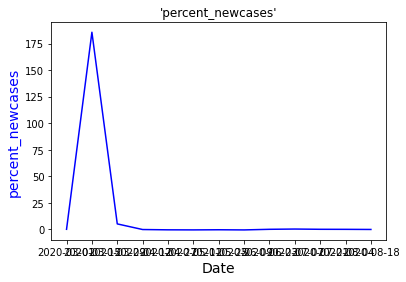

In [675]:
fig,ax = plt.subplots()
# make a plot
ax.plot(albany_county.startDate, albany_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(albany_county.startDate, albany_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [676]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 98.09090909090911, 0.0, 39.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.000000000000002, 140.00000000000003, 380.6666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 11.333333333333334, 0.0, 0.0, 0.0, 0.0, 175.79999999999998, 0.0, 106.37885462555064, 213.91325695581014, 0.0, 0.0, 0.0, 0.0, 410.1818181818182, 0.0, 0.0, 0.0, 0.0, 0.0, 170.28571428571428, 23.764705882352946, 179.50000000000006, 0.0, 0.0, 0.0, 0.0, 0.0, 185.66666666666666, 0.0, 12.0, 165.00000000000003, 21.421052631578945, 0.0, 0.0, 0.0, 39.33373493975903, 0.0, 0.0, 0.32935779816513777, 8.357142857142858, 6.123456790123455, 102.00000000000003, 9.800000000000002, 8.615384615384615, 7.657894736842104, 12.759999999999998, 2.672413793103449, 1.559210526315789

In [677]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

In [678]:
average_newCases_df3.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.0,NaN,0.0
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0
2,Broome County,36007,0.020408,2020-03-01,2020-03-14,0.0,NaN,0.0
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0


In [679]:
new_cases_list = average_newCases_df2['percent_newcases'].values

## Determining growth label for covid cases

#### Getting diff array

In [680]:
len(new_cases_list)

741

In [681]:
diffArr = np.diff(new_cases_list)
print(len(diffArr))
diffArr[0]

740


0.0

In [682]:
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))


growth_values :  1
growth_values :  741


In [683]:
len(growth_values)

741

In [684]:
average_newCases_df2['growth_per_day'] = growth_values

In [685]:
average_newCases_df2.dtypes

County Name          object
fips_x                int64
average_per_week    float64
startDate            object
endDate              object
diff_avg_x          float64
shift_avg_x         float64
percent_newcases    float64
growth_per_day      float64
dtype: object

### Checking mean, std dev and variance for growth data

In [686]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -410.1818181818182
max  410.1818181818182
mean  -0.0004914004914004339
std. deviation  35.93998712144793
variance  1291.682674289843


#### Getting positive cases

In [687]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))

length diffArr:  740
non_zero_pos_diff length:  331


In [688]:
stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  0.00011190308642550217
max  410.1818181818182
mean  7.574389359589591
std. deviation  35.36673657964142
variance  1250.8060562937465


#### Getting negative cases

In [689]:
print('length diffArr: ',len(diffArr))

non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))


length diffArr:  740
non_zero_neg_diff length :  325


In [690]:
stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -410.1818181818182
max  -0.0021092147528928296
mean  -7.715343121193205
std. deviation  39.359969154115035
variance  1549.2071718128868


### Trying natural breaks

In [691]:
!pip install jenkspy


In [692]:
import jenkspy


In [693]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)

[0.00011190308642550217, 39.5, 410.1818181818182]
[-410.1818181818182, -143.5789473684211, -0.0021092147528928296]


##### **Note**: 
From the positive and negative break, 
* [ -0.002109, 0.00011 ] - flat growth
* [ 0.00011, 39.5 ] - mild growth
* [ 39.5, 410.1818 ] - drastic growth
* [ -0.0021, -39.5 ] - mild decrement
* [ -39.5, -410.18 ] - drastic decrement

In [694]:
def determine_growth_label(x):
  if x >= -0.002109 and x <= 0.00011:
    return 'flat_growth'
  if x > 0.00011 and x <= 39.5:
    return 'mild_growth'
  if x > 39.5 and x <= 410.1818:
    return 'drastic_growth'
  if x >= -39.5  and x <= -0.0021:
    return 'mild_decrement'
  if x >= -410.18 and x < -39.5:
    return 'drastic_decrement'


In [695]:
average_newCases_df2['growth_label'] = average_newCases_df2['growth_per_day'].apply(lambda x: determine_growth_label(x) )

In [696]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
2,Broome County,36007,0.020408,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth


## Jenks Natural breaks 

In [697]:

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

[-1.1363636363636362, 39.5, 213.91325695581014, 410.1818181818182]


In [698]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)

[-1.1363636363636362, 3.6428571428571432, 13.625000000000002, 39.5, 106.37885462555064, 140.00000000000003, 185.66666666666666, 213.91325695581014, 410.1818181818182]


### Labeling criteria

We have applied "jenks Natural breaks' to label the county data as per 'percent change in cases'

From the natural break algorithm, we have splited the data as follows 

* -1.136 to 3.642 is **label 1** (least chance of spreading) 

* 3.642 to 13.625 is **label 2** (Below threshold but chances to reach super spread level)

* 13.625 to 410.181818 is **label 3** (Super spread week)

In [699]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])

In [700]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['County Name'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['County Name'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['County Name'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['County Name'].count())


print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['County Name'].count())

print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['County Name'].count())

print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['County Name'].count())

print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['County Name'].count())




Number of records in LessSpread: 680
Number of records in Spread: 42
Number of records in SuperSpread: 6
Number of records in SuperSpread2: 3
Number of records in SuperSpread3: 1
Number of records in SuperSpread4: 5
Number of records in SuperSpread5: 1
Number of records in SuperSpread6: 2


In [701]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=4)
print(breaks)

[-1.1363636363636362, 39.5, 140.00000000000003, 213.91325695581014, 410.1818181818182]


In [702]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread','SuperSpread2'])

In [703]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['County Name'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['County Name'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']['County Name'].count())

print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['County Name'].count())

Number of records in LessSpread: 728
Number of records in Spread: 4
Number of records in SuperSpread: 6
Number of records in SuperSpread: 2


In [704]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
2,Broome County,36007,0.020408,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread


# 1.3 Labeling data for NY combined

In [705]:
NY_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0,305506.0
9632,2020-03-01,36123,Yates County,31.0,33.0,0.0,0.0,7.0,0.0,28.14,5.004,72,73.676584,0,0.0,0,0.0,24913.0
1548,2020-03-01,36021,Columbia County,21.0,4.0,0.0,25.0,4.0,0.0,19.75,5.337,58,93.682154,0,0.0,0,0.0,59461.0
7224,2020-03-01,36095,Schoharie County,26.0,9.0,0.0,0.0,13.0,0.0,24.47,2.137,27,49.852047,0,0.0,0,0.0,30999.0
2580,2020-03-01,36033,Franklin County,28.0,27.0,0.0,0.0,7.0,0.0,10.82,2.205,56,30.704920,0,0.0,0,0.0,50022.0


In [706]:
NY_combined_data_ = NY_combined_data.copy()



In [707]:
NY_combined_data = NY_combined_data_.copy().reset_index(drop=True)

In [708]:
#average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in (average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['fips_x']
    #print(startDate,endDate,fips)
    df_index = (NY_combined_data['fips_x'] == row['fips_x']) & (NY_combined_data['Date'] >= startDate) & (NY_combined_data['Date'] <= endDate)
    df_weekData =  NY_combined_data.loc[df_index]
    #print(df_weekData)
    NY_combined_data.loc[df_index,'label'] = row['labels']
    NY_combined_data.loc[df_index,'growth_label'] = row['growth_label']




In [709]:
NY_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0,305506.0,LessSpread,flat_growth
1,2020-03-01,36123,Yates County,31.0,33.0,0.0,0.0,7.0,0.0,28.14,5.004,72,73.676584,0,0.0,0,0.0,24913.0,LessSpread,flat_growth
2,2020-03-01,36021,Columbia County,21.0,4.0,0.0,25.0,4.0,0.0,19.75,5.337,58,93.682154,0,0.0,0,0.0,59461.0,LessSpread,flat_growth
3,2020-03-01,36095,Schoharie County,26.0,9.0,0.0,0.0,13.0,0.0,24.47,2.137,27,49.852047,0,0.0,0,0.0,30999.0,LessSpread,flat_growth
4,2020-03-01,36033,Franklin County,28.0,27.0,0.0,0.0,7.0,0.0,10.82,2.205,56,30.704920,0,0.0,0,0.0,50022.0,LessSpread,flat_growth


In [710]:
NY_combined_data[NY_combined_data['label'] == 'SuperSpread2'].sort_values(by=['fips_x','Date']).count()

Date                     28
fips_x                   28
County Name              28
retail and recreation    28
grocery and pharmacy     28
parks                    28
transit stations         28
workplaces               28
residential              28
driving                  28
m50                      28
m50_index                28
population_density       28
mask_rule_active         28
mask_wearing_percent     28
New cases                28
rolling_avg_new_cases    28
population               28
label                    28
growth_label             14
dtype: int64

In [711]:
NY_combined_data.shape

(9804, 20)

In [712]:
NY_combined_data['label'] = NY_combined_data['label'].apply(lambda x: x if x != 'SuperSpread2' else 'SuperSpread')




In [713]:
NY_combined_data.dtypes

Date                      object
fips_x                     int64
County Name               object
retail and recreation    float64
grocery and pharmacy     float64
parks                    float64
transit stations         float64
workplaces               float64
residential              float64
driving                  float64
m50                      float64
m50_index                  int64
population_density       float64
mask_rule_active           int64
mask_wearing_percent     float64
New cases                  int64
rolling_avg_new_cases    float64
population               float64
label                     object
growth_label              object
dtype: object

In [714]:
NY_combined_data[NY_combined_data['label'] == 'LessSpread'].count()

Date                     9622
fips_x                   9622
County Name              9622
retail and recreation    9622
grocery and pharmacy     9622
parks                    9622
transit stations         9622
workplaces               9622
residential              9622
driving                  9622
m50                      9622
m50_index                9622
population_density       9622
mask_rule_active         9622
mask_wearing_percent     9622
New cases                9622
rolling_avg_new_cases    9622
population               9622
label                    9622
growth_label             9608
dtype: int64

In [715]:
NY_combined_data[NY_combined_data['growth_label'] == 'flat_growth'].count()

Date                     1190
fips_x                   1190
County Name              1190
retail and recreation    1190
grocery and pharmacy     1190
parks                    1190
transit stations         1190
workplaces               1190
residential              1190
driving                  1190
m50                      1190
m50_index                1190
population_density       1190
mask_rule_active         1190
mask_wearing_percent     1190
New cases                1190
rolling_avg_new_cases    1190
population               1190
label                    1190
growth_label             1190
dtype: int64

## Computing new cases per 1k population

In [824]:
NY_combined_data['New Cases/1k population'] = NY_combined_data['New cases']*1000/ NY_combined_data['population']
NY_combined_data.tail(2)


,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population
9802,2020-08-21,36103,Suffolk County,0.0,0.0,0.0,0.0,-34.0,8.0,90.77,6.886,79,1618.991283,1,0.782,47,50.714286,1476601.0,LessSpread,mild_decrement,0.03183
9803,2020-08-21,36123,Yates County,0.0,0.0,0.0,0.0,-22.0,0.0,366.07,10.392,149,73.676584,1,0.884,0,0.142857,24913.0,LessSpread,mild_decrement,0.00000


In [825]:
new_cases_10k_list = NY_combined_data['New Cases/1k population'].values

In [826]:
diffArr = np.diff(new_cases_10k_list)
print(len(diffArr))
diffArr[0]

growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

9803
growth_values :  1
growth_values :  9804


In [827]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


min  -4.811795376206633
max  4.811795376206633
mean  -6.306798396798266e-19
std. deviation  0.28728930724489277
variance  0.08253514605725039


## Getting positive cases

In [828]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))


stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

length diffArr:  9803
non_zero_pos_diff length:  3974
min  1.1045153360346449e-05
max  4.811795376206633
mean  0.1087484582459184
std. deviation  0.2987118746218257
variance  0.0892287840400853


## Getting negative cases


In [829]:
non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))

stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


non_zero_neg_diff length :  4038
min  -4.811795376206633
max  -9.454894623110721e-06
mean  -0.1070248571246359
std. deviation  0.2991017085776531
variance  0.08946183207407134


## Applying natural breaks

In [830]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)

[1.1045153360346449e-05, 0.835960519245697, 4.811795376206633]
[-4.811795376206633, -1.0427002573115152, -9.454894623110721e-06]


In [831]:
def determine_growth_label_1k(x):
  if x >= -0.00000945 and x <= 0.00001:
    return 'flat_growth'
  if x > 0.00001 and x <= 0.83596:
    return 'mild_growth'
  if x > 0.83596 and x <= 4.8117:
    return 'drastic_growth'
  if x >= -4.8117  and x <= -1.042:
    return 'mild_decrement'
  if x >= -9.454 and x < -1.042:
    return 'drastic_decrement'

In [832]:
NY_combined_data['growth_label_1k'] = NY_combined_data['New Cases/1k population'].apply(lambda x: determine_growth_label_1k(x) )
NY_combined_data.head(4)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0,305506.0,LessSpread,flat_growth,0.0,flat_growth
1,2020-03-01,36123,Yates County,31.0,33.0,0.0,0.0,7.0,0.0,28.14,5.004,72,73.676584,0,0.0,0,0.0,24913.0,LessSpread,flat_growth,0.0,flat_growth
2,2020-03-01,36021,Columbia County,21.0,4.0,0.0,25.0,4.0,0.0,19.75,5.337,58,93.682154,0,0.0,0,0.0,59461.0,LessSpread,flat_growth,0.0,flat_growth
3,2020-03-01,36095,Schoharie County,26.0,9.0,0.0,0.0,13.0,0.0,24.47,2.137,27,49.852047,0,0.0,0,0.0,30999.0,LessSpread,flat_growth,0.0,flat_growth


In [833]:
NY_combined_data.to_csv('NY_labeledData_Sep24.csv',index=False)

In [718]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels
81,Monroe County,36055,9.020408,2020-03-15,2020-03-28,8.969388,0.051020,175.800000,175.800000,drastic_growth,SuperSpread
84,New York County,36061,1339.918367,2020-03-15,2020-03-28,1333.683673,6.234694,213.913257,107.534402,drastic_growth,SuperSpread
95,Rockland County,36087,73.408163,2020-03-15,2020-03-28,72.979592,0.428571,170.285714,170.285714,drastic_growth,SuperSpread
97,Schenectady County,36093,3.683673,2020-03-15,2020-03-28,3.663265,0.020408,179.500000,155.735294,drastic_growth,SuperSpread
103,Suffolk County,36103,171.428571,2020-03-15,2020-03-28,170.510204,0.918367,185.666667,185.666667,drastic_growth,SuperSpread
106,Tompkins County,36109,1.693878,2020-03-15,2020-03-28,1.683673,0.010204,165.000000,153.000000,drastic_growth,SuperSpread


## Kernal Density Estimation

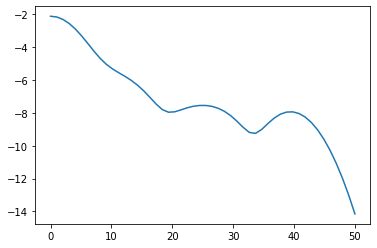

In [719]:
%matplotlib inline

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = array(data).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [720]:


from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

Minima: [19.3877551  33.67346939]
Maxima: [24.48979592 39.79591837]


In [721]:
lower_range = s[mi][0]
upper_range = s[mi][1]

lower_range

19.387755102040817

In [722]:
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

[-1.1363636363636362, 39.5, 213.91325695581014, 410.1818181818182]

Minima: [19.3877551  33.67346939]
Maxima: [24.48979592 39.79591837]*italicized text*

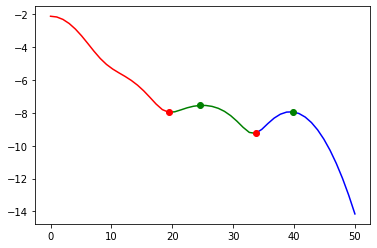

In [723]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


## Labeling Data with Kernal density results

In [724]:
average_newCases_df3.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.0,NaN,0.0
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0
2,Broome County,36007,0.020408,2020-03-01,2020-03-14,0.0,NaN,0.0
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0


In [725]:
print(lower_range, upper_range)

19.387755102040817 33.673469387755105


In [726]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range  else 'SuperSpread')


In [727]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range else ('Spread' if (x >= lower_range and x <= upper_range) else 'SuperSpread'))



#converter = lambda x : x*2 if x < 10 else (x*3 if x < 20 else x)



In [728]:
average_newCases_df3[average_newCases_df3['label'] == 'lessSpread'].count()

County Name         723
fips_x              723
average_per_week    723
startDate           723
endDate             723
diff_avg_x          723
shift_avg_x         666
percent_newcases    723
label               723
dtype: int64

In [729]:
average_newCases_df3[average_newCases_df3['label'] == 'Spread'].count()

County Name         4
fips_x              4
average_per_week    4
startDate           4
endDate             4
diff_avg_x          4
shift_avg_x         4
percent_newcases    4
label               4
dtype: int64

In [730]:
average_newCases_df3[average_newCases_df3['label'] == 'SuperSpread'].count()

County Name         14
fips_x              14
average_per_week    14
startDate           14
endDate             14
diff_avg_x          14
shift_avg_x         14
percent_newcases    14
label               14
dtype: int64

In [731]:
average_newCases_df3.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,label
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
2,Broome County,36007,0.020408,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread


# 2.1 Loading NY - Social Distancing Inertia Maryland Data

In [732]:
NY_combined_sd_inertia_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/NY_socialDistancingInertiaDataSep24.csv',low_memory=False)
NY_combined_sd_inertia_data.head()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases
0,2020-01-22,New York,36001,0,0,0,0,0,36001,Albany County,36,20,21,4.32,40.3,2.3,35.4,1.06,3.25,0,307117,0.4,2020-01-22,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0,0.8,3.7,4.2,0.7,0.0,0.0,0.0,0,63.5,0.0,0.0,0.0,0,0
1,2020-01-23,New York,36001,0,0,0,0,0,36001,Albany County,36,15,19,4.46,39.6,2.5,37.9,1.08,3.38,0,307117,4.4,2020-01-23,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0,0.8,3.7,4.2,0.7,0.0,0.0,0.0,0,63.5,0.0,0.0,0.0,0,0
2,2020-01-24,New York,36001,0,0,0,0,0,36001,Albany County,36,15,19,4.62,39.0,2.4,41.3,1.07,3.56,0,307117,10.0,2020-01-24,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0,0.8,3.7,4.2,0.7,0.0,0.0,0.0,0,63.5,0.0,0.0,0.0,0,0
3,2020-01-25,New York,36001,0,0,0,0,0,36001,Albany County,36,33,26,3.87,36.9,2.4,38.8,0.46,3.41,0,307117,5.3,2020-01-25,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0,0.8,3.7,4.2,0.7,0.0,0.0,0.0,1,63.5,0.0,0.0,0.0,0,0
4,2020-01-26,New York,36001,0,0,0,0,0,36001,Albany County,36,47,31,3.35,35.8,3.1,34.8,0.41,2.94,0,307117,-9.2,2020-01-26,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0,0.9,3.7,4.2,0.7,0.0,0.0,0.0,2,63.5,0.0,0.0,0.0,0,0


In [733]:
NY_combined_sd_inertia_data.FIPS.unique()

array([36001, 36003, 36007, 36009, 36011, 36013, 36015, 36017, 36019,
       36021, 36023, 36025, 36027, 36029, 36031, 36033, 36035, 36037,
       36039, 36041, 36043, 36045, 36049, 36051, 36053, 36055, 36057,
       36059, 36061, 36063, 36065, 36067, 36069, 36071, 36073, 36075,
       36077, 36079, 36083, 36087, 36089, 36091, 36093, 36095, 36097,
       36099, 36101, 36103, 36105, 36107, 36109, 36111, 36113, 36115,
       36117, 36119, 36121, 36123])

## Computing rolling average

In [734]:
NY_combined_sd_inertia_data.columns

Index(['Date', 'Province_State', 'FIPS', 'Confirmed', 'Deaths', 'New cases',
       'New deaths', 'mask_rule_active', 'CTFIPS', 'CTNAME', 'STFIPS',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation

In [735]:
#new case column nume = 5
NY_combined_sd_inertia_data.iloc[:,5]

0        0
1        0
2        0
3        0
4        0
        ..
12291    0
12292    0
12293    0
12294    0
12295    0
Name: New cases, Length: 12296, dtype: int64

removing comuns: 
'Confirmed', 'Deaths', 'New deaths','#days: decreasing ILI cases', '#days: decreasing COVID cases', 'New cases/1000 people', 'Imported COVID cases' ,'COVID death rate',  'Active cases/1000 people',

In [736]:
df = pd.DataFrame(columns=['Date', 'Province_State', 'FIPS',  'New cases',
        'mask_rule_active', 'CTFIPS', 'CTNAME', 'STFIPS',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
        'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate',
        '% hospital bed utilization',
       'Testing capacity', 'Tests done/1000 people', '% ICU utilization',
       'Ventilator shortage'])


In [737]:
NY_counties = NY_combined_sd_inertia_data['CTNAME'].unique()

for county in NY_counties:
  county_data = NY_combined_sd_inertia_data[NY_combined_sd_inertia_data['CTNAME'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,5].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,New York,36001,0,0,36001,Albany County,36,20,21,4.32,40.3,2.3,35.4,1.06,3.25,0,307117,0.4,2020-01-22,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2020-01-23,New York,36001,0,0,36001,Albany County,36,15,19,4.46,39.6,2.5,37.9,1.08,3.38,0,307117,4.4,2020-01-23,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2020-01-24,New York,36001,0,0,36001,Albany County,36,15,19,4.62,39.0,2.4,41.3,1.07,3.56,0,307117,10.0,2020-01-24,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,2020-01-25,New York,36001,0,0,36001,Albany County,36,33,26,3.87,36.9,2.4,38.8,0.46,3.41,0,307117,5.3,2020-01-25,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
4,2020-01-26,New York,36001,0,0,36001,Albany County,36,47,31,3.35,35.8,3.1,34.8,0.41,2.94,0,307117,-9.2,2020-01-26,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.9,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,NaN


In [738]:
print(df.shape)
NY_combined_sd_inertia_data.shape

(12296, 54)


(12296, 53)

In [739]:
NY_combined_sd_inertia_data = df.copy()
NY_combined_sd_inertia_data

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,New York,36001,0,0,36001,Albany County,36,20,21,4.32,40.3,2.3,35.4,1.06,3.25,0,307117,0.4,2020-01-22,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.00,0.8,3.7,4.2,0.70,63.500000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,NaN
1,2020-01-23,New York,36001,0,0,36001,Albany County,36,15,19,4.46,39.6,2.5,37.9,1.08,3.38,0,307117,4.4,2020-01-23,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.00,0.8,3.7,4.2,0.70,63.500000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,NaN
2,2020-01-24,New York,36001,0,0,36001,Albany County,36,15,19,4.62,39.0,2.4,41.3,1.07,3.56,0,307117,10.0,2020-01-24,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.00,0.8,3.7,4.2,0.70,63.500000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,NaN
3,2020-01-25,New York,36001,0,0,36001,Albany County,36,33,26,3.87,36.9,2.4,38.8,0.46,3.41,0,307117,5.3,2020-01-25,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.00,0.8,3.7,4.2,0.70,63.500000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,1.0,0.0,NaN
4,2020-01-26,New York,36001,0,0,36001,Albany County,36,47,31,3.35,35.8,3.1,34.8,0.41,2.94,0,307117,-9.2,2020-01-26,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.00,0.9,3.7,4.2,0.70,63.500000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,2.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12291,2020-08-16,New York,36123,0,1,36123,Yates County,36,23,20,4.31,48.7,2.6,66.7,0.51,3.80,0,24841,12.1,2020-08-16,0.34,27,54343,0.8,2.2,47.98,67,20,128,2.74,0.22,0.029,37.0,67,54.67,2.7,23.7,29.9,1.81,64.273653,6.0,361.69,2.98,92,59.0,7.0,0.0,140.0,3.07,0.0134,1.00,1.0,33.0,0.285714
12292,2020-08-17,New York,36123,0,1,36123,Yates County,36,25,22,4.16,43.0,1.5,55.5,0.66,3.50,0,24841,3.2,2020-08-17,0.34,27,54343,0.8,2.2,47.98,67,20,128,2.74,0.22,0.029,37.0,67,54.67,2.7,23.7,29.9,1.81,64.260908,6.0,364.60,3.09,91,59.0,7.0,0.0,140.0,3.07,0.0134,0.99,2.0,27.0,0.285714
12293,2020-08-18,New York,36123,0,1,36123,Yates County,36,24,21,4.02,42.8,1.0,56.0,0.79,3.23,0,24841,-4.7,2020-08-18,0.34,27,54343,0.8,2.2,47.98,67,20,128,2.74,0.22,0.029,37.0,67,54.67,2.7,23.7,29.9,1.81,64.248129,5.9,368.02,2.93,89,59.0,7.0,0.0,140.0,3.07,0.0000,0.99,0.0,27.0,0.285714
12294,2020-08-19,New York,36123,0,1,36123,Yates County,36,23,19,4.53,42.0,0.8,52.8,0.53,4.00,0,24841,18.0,2020-08-19,0.34,27,54343,0.8,2.2,47.98,67,20,128,2.74,0.22,0.029,37.0,67,54.67,2.7,23.7,29.9,1.81,63.533417,5.9,372.14,3.05,4,59.0,7.0,0.0,140.0,3.07,0.0000,1.00,0.0,30.0,0.285714


In [740]:
NY_combined_sd_inertia_data.head(3)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,New York,36001,0,0,36001,Albany County,36,20,21,4.32,40.3,2.3,35.4,1.06,3.25,0,307117,0.4,2020-01-22,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2020-01-23,New York,36001,0,0,36001,Albany County,36,15,19,4.46,39.6,2.5,37.9,1.08,3.38,0,307117,4.4,2020-01-23,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2020-01-24,New York,36001,0,0,36001,Albany County,36,15,19,4.62,39.0,2.4,41.3,1.07,3.56,0,307117,10.0,2020-01-24,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## clean data - fill NA 

In [741]:
NY_combined_sd_inertia_data = NY_combined_sd_inertia_data.fillna(0)
NY_combined_sd_inertia_data.head(4)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,New York,36001,0,0,36001,Albany County,36,20,21,4.32,40.3,2.3,35.4,1.06,3.25,0,307117,0.4,2020-01-22,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,New York,36001,0,0,36001,Albany County,36,15,19,4.46,39.6,2.5,37.9,1.08,3.38,0,307117,4.4,2020-01-23,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,New York,36001,0,0,36001,Albany County,36,15,19,4.62,39.0,2.4,41.3,1.07,3.56,0,307117,10.0,2020-01-24,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,New York,36001,0,0,36001,Albany County,36,33,26,3.87,36.9,2.4,38.8,0.46,3.41,0,307117,5.3,2020-01-25,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [742]:
NY_combined_sd_inertia_data['CTNAME'].unique()

array(['Albany County', 'Allegany County', 'Broome County',
       'Cattaraugus County', 'Cayuga County', 'Chautauqua County',
       'Chemung County', 'Chenango County', 'Clinton County',
       'Columbia County', 'Cortland County', 'Delaware County',
       'Dutchess County', 'Erie County', 'Essex County',
       'Franklin County', 'Fulton County', 'Genesee County',
       'Greene County', 'Hamilton County', 'Herkimer County',
       'Jefferson County', 'Lewis County', 'Livingston County',
       'Madison County', 'Monroe County', 'Montgomery County',
       'Nassau County', 'New York County', 'Niagara County',
       'Oneida County', 'Onondaga County', 'Ontario County',
       'Orange County', 'Orleans County', 'Oswego County',
       'Otsego County', 'Putnam County', 'Rensselaer County',
       'Rockland County', 'St. Lawrence County', 'Saratoga County',
       'Schenectady County', 'Schoharie County', 'Schuyler County',
       'Seneca County', 'Steuben County', 'Suffolk County',
 

## verifying Rolling average with visualizations

In [743]:
albany_county = NY_combined_sd_inertia_data[NY_combined_sd_inertia_data['CTNAME'] == 'Albany County']
print(albany_county.shape)
albany_county.head()

(212, 54)


,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,New York,36001,0,0,36001,Albany County,36,20,21,4.32,40.3,2.3,35.4,1.06,3.25,0,307117,0.4,2020-01-22,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,New York,36001,0,0,36001,Albany County,36,15,19,4.46,39.6,2.5,37.9,1.08,3.38,0,307117,4.4,2020-01-23,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,New York,36001,0,0,36001,Albany County,36,15,19,4.62,39.0,2.4,41.3,1.07,3.56,0,307117,10.0,2020-01-24,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,New York,36001,0,0,36001,Albany County,36,33,26,3.87,36.9,2.4,38.8,0.46,3.41,0,307117,5.3,2020-01-25,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2020-01-26,New York,36001,0,0,36001,Albany County,36,47,31,3.35,35.8,3.1,34.8,0.41,2.94,0,307117,-9.2,2020-01-26,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.9,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


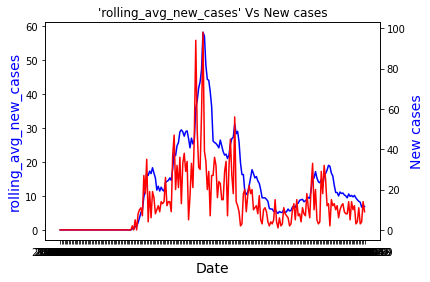

In [744]:
fig,ax = plt.subplots()
# make a plot
ax.plot(albany_county.Date, albany_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(albany_county.Date, albany_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

In [745]:
suffolk_county = NY_combined_sd_inertia_data[NY_combined_sd_inertia_data['CTNAME'] == 'Suffolk County']

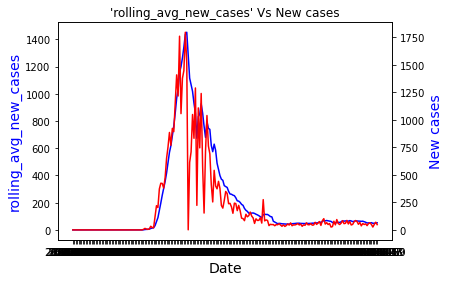

In [746]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## Rolling window to compare every 2 weeks with next 2 weeks

In [747]:
NY_combined_sd_inertia_data = NY_combined_sd_inertia_data.sort_values(by=['Date'])
NY_combined_sd_inertia_data.head()

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,New York,36001,0,0,36001,Albany County,36,20,21,4.32,40.3,2.3,35.4,1.06,3.25,0,307117,0.4,2020-01-22,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4240,2020-01-22,New York,36043,0,0,36043,Herkimer County,36,16,20,4.29,35.2,0.4,47.9,1.04,3.25,0,61833,-0.7,2020-01-22,1.04,27,51862,1.1,2.1,49.46,43,12,106,2.74,0.22,0.029,37.0,67,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4028,2020-01-22,New York,36041,0,0,36041,Hamilton County,36,13,16,4.31,37.6,1.6,67.0,0.28,4.03,0,4434,7.0,2020-01-22,0.37,36,57552,0.8,1.6,51.30,3,1,249,2.74,0.22,0.029,37.0,96,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10812,2020-01-22,New York,36111,0,0,36111,Ulster County,36,17,21,4.29,29.4,1.9,45.6,0.92,3.38,0,178599,5.7,2020-01-22,2.47,26,63348,5.4,10.0,49.51,154,86,144,2.74,0.22,0.029,37.0,59,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3816,2020-01-22,New York,36039,0,0,36039,Greene County,36,15,17,4.22,38.9,2.3,53.0,0.92,3.30,0,47491,-4.0,2020-01-22,1.13,29,53617,5.8,5.8,52.30,72,24,135,2.74,0.22,0.029,37.0,78,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [748]:
NY_combined_sd_inertia_data[NY_combined_sd_inertia_data['FIPS'] == 36001]

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,New York,36001,0,0,36001,Albany County,36,20,21,4.32,40.3,2.3,35.4,1.06,3.25,0,307117,0.4,2020-01-22,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.00,0.8,3.7,4.2,0.70,63.500000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,0.000000
1,2020-01-23,New York,36001,0,0,36001,Albany County,36,15,19,4.46,39.6,2.5,37.9,1.08,3.38,0,307117,4.4,2020-01-23,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.00,0.8,3.7,4.2,0.70,63.500000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,0.000000
2,2020-01-24,New York,36001,0,0,36001,Albany County,36,15,19,4.62,39.0,2.4,41.3,1.07,3.56,0,307117,10.0,2020-01-24,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.00,0.8,3.7,4.2,0.70,63.500000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0,0.000000
3,2020-01-25,New York,36001,0,0,36001,Albany County,36,33,26,3.87,36.9,2.4,38.8,0.46,3.41,0,307117,5.3,2020-01-25,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.00,0.8,3.7,4.2,0.70,63.500000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,1.0,0.0,0.000000
4,2020-01-26,New York,36001,0,0,36001,Albany County,36,47,31,3.35,35.8,3.1,34.8,0.41,2.94,0,307117,-9.2,2020-01-26,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.00,0.9,3.7,4.2,0.70,63.500000,0.0,0.00,0.00,0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,2.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,2020-08-16,New York,36001,11,1,36001,Albany County,36,37,29,4.08,33.8,3.1,44.0,0.33,3.75,11,307117,15.8,2020-08-16,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,54.67,2.7,23.7,29.9,1.81,64.273653,6.0,361.69,2.98,92,2654.0,129.0,0.0,140.0,3.07,0.0195,1.00,7.0,255.0,8.428571
208,2020-08-17,New York,36001,3,1,36001,Albany County,36,31,28,4.24,35.9,2.7,46.3,0.63,3.61,3,307117,11.5,2020-08-17,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,54.67,2.7,23.7,29.9,1.81,64.260908,6.0,364.60,3.09,91,2657.0,129.0,0.0,140.0,3.07,0.0195,0.99,8.0,290.0,8.142857
209,2020-08-18,New York,36001,4,1,36001,Albany County,36,29,27,4.18,36.7,2.6,43.9,0.69,3.49,4,307117,7.8,2020-08-18,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,54.67,2.7,23.7,29.9,1.81,64.248129,5.9,368.02,2.93,89,2661.0,129.0,0.0,140.0,3.07,0.0195,0.99,9.0,287.0,6.714286
210,2020-08-19,New York,36001,14,1,36001,Albany County,36,27,26,4.50,36.3,2.7,46.5,0.64,3.86,14,307117,19.2,2020-08-19,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,54.67,2.7,23.7,29.9,1.81,63.533417,5.9,372.14,3.05,4,2675.0,129.0,0.0,140.0,3.07,0.0228,1.00,10.0,318.0,7.285714


In [749]:
minDate = NY_combined_sd_inertia_data['Date'].min()
print(minDate)

dateList = NY_combined_sd_inertia_data['Date'].unique()

2020-01-22


In [750]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

3


In [751]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)
  


[1, '2020-01-22', '2020-02-01']
[2, '2020-02-02', '2020-02-15']
[3, '2020-02-16', '2020-02-29']
[4, '2020-03-01', '2020-03-14']
[5, '2020-03-15', '2020-03-28']
[6, '2020-03-29', '2020-04-11']
[7, '2020-04-12', '2020-04-25']
[8, '2020-04-26', '2020-05-09']
[9, '2020-05-10', '2020-05-23']
[10, '2020-05-24', '2020-06-06']
[11, '2020-06-07', '2020-06-20']
[12, '2020-06-21', '2020-07-04']
[13, '2020-07-05', '2020-07-18']
[14, '2020-07-19', '2020-08-01']
[15, '2020-08-02', '2020-08-15']
[16, '2020-08-16', '2020-08-20']


In [752]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head(2)

,WeekNumber,startDate,endDate
0,1,2020-01-22,2020-02-01
1,2,2020-02-02,2020-02-15


## Slice data for the week dataframe

In [753]:

average_newCases_df = pd.DataFrame(columns=['CTNAME',  'FIPS',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (NY_combined_sd_inertia_data['Date'] >= startDate) & (NY_combined_sd_inertia_data['Date'] <= endDate)
    df_weekData =  NY_combined_sd_inertia_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['CTNAME','FIPS'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)


In [754]:
average_newCases_df.shape

(928, 5)

In [755]:
average_newCases_df[average_newCases_df['FIPS'] == 36001]

,CTNAME,FIPS,average_per_week,startDate,endDate
0,Albany County,36001,0.000000,2020-01-22,2020-02-01
0,Albany County,36001,0.000000,2020-02-02,2020-02-15
0,Albany County,36001,0.000000,2020-02-16,2020-02-29
0,Albany County,36001,0.112245,2020-03-01,2020-03-14
0,Albany County,36001,11.122449,2020-03-15,2020-03-28
0,Albany County,36001,14.785714,2020-03-29,2020-04-11
0,Albany County,36001,27.775510,2020-04-12,2020-04-25
0,Albany County,36001,41.183673,2020-04-26,2020-05-09
0,Albany County,36001,24.938776,2020-05-10,2020-05-23
0,Albany County,36001,16.673469,2020-05-24,2020-06-06


## Verifying average per week data Eg., albany County

In [756]:
albany_county[(albany_county['Date'] >= '2020-03-01') & (albany_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']



39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
44    0.000000
45    0.000000
46    0.000000
47    0.000000
48    0.000000
49    0.000000
50    0.285714
51    0.285714
52    1.000000
Name: rolling_avg_new_cases, dtype: float64

In [757]:
average_newCases_df.head(10)

,CTNAME,FIPS,average_per_week,startDate,endDate
0,Albany County,36001,0.0,2020-01-22,2020-02-01
1,Allegany County,36003,0.0,2020-01-22,2020-02-01
2,Broome County,36007,0.0,2020-01-22,2020-02-01
3,Cattaraugus County,36009,0.0,2020-01-22,2020-02-01
4,Cayuga County,36011,0.0,2020-01-22,2020-02-01
5,Chautauqua County,36013,0.0,2020-01-22,2020-02-01
6,Chemung County,36015,0.0,2020-01-22,2020-02-01
7,Chenango County,36017,0.0,2020-01-22,2020-02-01
8,Clinton County,36019,0.0,2020-01-22,2020-02-01
9,Columbia County,36021,0.0,2020-01-22,2020-02-01


## Finding the % growth or reduction in 'new cases' on every 2 week average

In [758]:
average_newCases_df_ = average_newCases_df.copy()

In [759]:
albany_avg_newCases = average_newCases_df[average_newCases_df['CTNAME'] == 'Albany County']
albany_avg_newCases

,CTNAME,FIPS,average_per_week,startDate,endDate
0,Albany County,36001,0.000000,2020-01-22,2020-02-01
0,Albany County,36001,0.000000,2020-02-02,2020-02-15
0,Albany County,36001,0.000000,2020-02-16,2020-02-29
0,Albany County,36001,0.112245,2020-03-01,2020-03-14
0,Albany County,36001,11.122449,2020-03-15,2020-03-28
0,Albany County,36001,14.785714,2020-03-29,2020-04-11
0,Albany County,36001,27.775510,2020-04-12,2020-04-25
0,Albany County,36001,41.183673,2020-04-26,2020-05-09
0,Albany County,36001,24.938776,2020-05-10,2020-05-23
0,Albany County,36001,16.673469,2020-05-24,2020-06-06


In [760]:
average_newCases_df.head()

,CTNAME,FIPS,average_per_week,startDate,endDate
0,Albany County,36001,0.0,2020-01-22,2020-02-01
1,Allegany County,36003,0.0,2020-01-22,2020-02-01
2,Broome County,36007,0.0,2020-01-22,2020-02-01
3,Cattaraugus County,36009,0.0,2020-01-22,2020-02-01
4,Cayuga County,36011,0.0,2020-01-22,2020-02-01


In [761]:
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate
0,Albany County,36001,0.0,2020-01-22,2020-02-01
1,Allegany County,36003,0.0,2020-01-22,2020-02-01
2,Broome County,36007,0.0,2020-01-22,2020-02-01
3,Cattaraugus County,36009,0.0,2020-01-22,2020-02-01
4,Cayuga County,36011,0.0,2020-01-22,2020-02-01


In [762]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['CTNAME', 'FIPS'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()


(928, 6)


,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,Albany County,36001,0.0,2020-01-22,2020-02-01,0.0
1,Allegany County,36003,0.0,2020-01-22,2020-02-01,0.0
2,Broome County,36007,0.0,2020-01-22,2020-02-01,0.0
3,Cattaraugus County,36009,0.0,2020-01-22,2020-02-01,0.0
4,Cayuga County,36011,0.0,2020-01-22,2020-02-01,0.0


In [763]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Yates County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
57,Yates County,36123,0.000000,2020-01-22,2020-02-01,0.000000
115,Yates County,36123,0.000000,2020-02-02,2020-02-15,0.000000
173,Yates County,36123,0.000000,2020-02-16,2020-02-29,0.000000
231,Yates County,36123,0.000000,2020-03-01,2020-03-14,0.000000
289,Yates County,36123,0.000000,2020-03-15,2020-03-28,0.000000
347,Yates County,36123,0.091837,2020-03-29,2020-04-11,0.091837
405,Yates County,36123,0.704082,2020-04-12,2020-04-25,0.612245
463,Yates County,36123,0.581633,2020-04-26,2020-05-09,-0.122449
521,Yates County,36123,0.795918,2020-05-10,2020-05-23,0.214286
579,Yates County,36123,0.612245,2020-05-24,2020-06-06,-0.183673


In [764]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Albany County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,Albany County,36001,0.000000,2020-01-22,2020-02-01,0.000000
58,Albany County,36001,0.000000,2020-02-02,2020-02-15,0.000000
116,Albany County,36001,0.000000,2020-02-16,2020-02-29,0.000000
174,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.112245
232,Albany County,36001,11.122449,2020-03-15,2020-03-28,11.010204
290,Albany County,36001,14.785714,2020-03-29,2020-04-11,3.663265
348,Albany County,36001,27.775510,2020-04-12,2020-04-25,12.989796
406,Albany County,36001,41.183673,2020-04-26,2020-05-09,13.408163
464,Albany County,36001,24.938776,2020-05-10,2020-05-23,-16.244898
522,Albany County,36001,16.673469,2020-05-24,2020-06-06,-8.265306


In [765]:
average_newCases_df2[average_newCases_df2['FIPS'] == 36071].head(5)

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
33,Orange County,36071,0.000000,2020-01-22,2020-02-01,0.000000
91,Orange County,36071,0.000000,2020-02-02,2020-02-15,0.000000
149,Orange County,36071,0.000000,2020-02-16,2020-02-29,0.000000
207,Orange County,36071,0.112245,2020-03-01,2020-03-14,0.112245
265,Orange County,36071,46.153061,2020-03-15,2020-03-28,46.040816


In [766]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Yates County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
57,Yates County,36123,0.000000,2020-01-22,2020-02-01,0.000000
115,Yates County,36123,0.000000,2020-02-02,2020-02-15,0.000000
173,Yates County,36123,0.000000,2020-02-16,2020-02-29,0.000000
231,Yates County,36123,0.000000,2020-03-01,2020-03-14,0.000000
289,Yates County,36123,0.000000,2020-03-15,2020-03-28,0.000000
347,Yates County,36123,0.091837,2020-03-29,2020-04-11,0.091837
405,Yates County,36123,0.704082,2020-04-12,2020-04-25,0.612245
463,Yates County,36123,0.581633,2020-04-26,2020-05-09,-0.122449
521,Yates County,36123,0.795918,2020-05-10,2020-05-23,0.214286
579,Yates County,36123,0.612245,2020-05-24,2020-06-06,-0.183673


In [767]:
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,Albany County,36001,0.0,2020-01-22,2020-02-01,0.0
1,Allegany County,36003,0.0,2020-01-22,2020-02-01,0.0
2,Broome County,36007,0.0,2020-01-22,2020-02-01,0.0
3,Cattaraugus County,36009,0.0,2020-01-22,2020-02-01,0.0
4,Cayuga County,36011,0.0,2020-01-22,2020-02-01,0.0


In [768]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [769]:
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,Albany County,36001,0.0,2020-01-22,2020-02-01,0.0
1,Allegany County,36003,0.0,2020-01-22,2020-02-01,0.0
2,Broome County,36007,0.0,2020-01-22,2020-02-01,0.0
3,Cattaraugus County,36009,0.0,2020-01-22,2020-02-01,0.0
4,Cayuga County,36011,0.0,2020-01-22,2020-02-01,0.0


Shifting average_per_week_x	 column value for formula. Means previous row's value will be come to the current row.

In [770]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['CTNAME', 'FIPS'])['average_per_week'].shift()

In [771]:
average_newCases_df2.groupby(by=['CTNAME', 'FIPS','startDate','endDate']).sum()

average_per_week  ...  shift_avg_x
CTNAME        FIPS  startDate  endDate                       ...             
Albany County 36001 2020-01-22 2020-02-01          0.000000  ...     0.000000
                    2020-02-02 2020-02-15          0.000000  ...     0.000000
                    2020-02-16 2020-02-29          0.000000  ...     0.000000
                    2020-03-01 2020-03-14          0.112245  ...     0.000000
                    2020-03-15 2020-03-28         11.122449  ...     0.112245
...                                                     ...  ...          ...
Yates County  36123 2020-06-21 2020-07-04          0.428571  ...     0.081633
                    2020-07-05 2020-07-18          0.244898  ...     0.428571
                    2020-07-19 2020-08-01          0.204082  ...     0.244898
                    2020-08-02 2020-08-15          0.367347  ...     0.204082
                    2020-08-16 2020-08-20          0.257143  ...     0.367347

[928 rows x 3 columns]

In [772]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Yates County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x
57,Yates County,36123,0.000000,2020-01-22,2020-02-01,0.000000,NaN
115,Yates County,36123,0.000000,2020-02-02,2020-02-15,0.000000,0.000000
173,Yates County,36123,0.000000,2020-02-16,2020-02-29,0.000000,0.000000
231,Yates County,36123,0.000000,2020-03-01,2020-03-14,0.000000,0.000000
289,Yates County,36123,0.000000,2020-03-15,2020-03-28,0.000000,0.000000
347,Yates County,36123,0.091837,2020-03-29,2020-04-11,0.091837,0.000000
405,Yates County,36123,0.704082,2020-04-12,2020-04-25,0.612245,0.091837
463,Yates County,36123,0.581633,2020-04-26,2020-05-09,-0.122449,0.704082
521,Yates County,36123,0.795918,2020-05-10,2020-05-23,0.214286,0.581633
579,Yates County,36123,0.612245,2020-05-24,2020-06-06,-0.183673,0.795918


In [773]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()


,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
923,Washington County,36115,0.314286,2020-08-16,2020-08-20,-0.114286,0.428571,-0.266667
924,Wayne County,36117,2.085714,2020-08-16,2020-08-20,1.004082,1.081633,0.928302
925,Westchester County,36119,35.342857,2020-08-16,2020-08-20,3.506122,31.836735,0.110128
926,Wyoming County,36121,0.171429,2020-08-16,2020-08-20,-0.328571,0.500000,-0.657143
927,Yates County,36123,0.257143,2020-08-16,2020-08-20,-0.110204,0.367347,-0.300000


In [774]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Yates County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
57,Yates County,36123,0.000000,2020-01-22,2020-02-01,0.000000,NaN,0.000000
115,Yates County,36123,0.000000,2020-02-02,2020-02-15,0.000000,0.000000,0.000000
173,Yates County,36123,0.000000,2020-02-16,2020-02-29,0.000000,0.000000,0.000000
231,Yates County,36123,0.000000,2020-03-01,2020-03-14,0.000000,0.000000,0.000000
289,Yates County,36123,0.000000,2020-03-15,2020-03-28,0.000000,0.000000,0.000000
347,Yates County,36123,0.091837,2020-03-29,2020-04-11,0.091837,0.000000,0.000000
405,Yates County,36123,0.704082,2020-04-12,2020-04-25,0.612245,0.091837,6.666667
463,Yates County,36123,0.581633,2020-04-26,2020-05-09,-0.122449,0.704082,-0.173913
521,Yates County,36123,0.795918,2020-05-10,2020-05-23,0.214286,0.581633,0.368421
579,Yates County,36123,0.612245,2020-05-24,2020-06-06,-0.183673,0.795918,-0.230769


# 2.2 Labeling data as per % change

In [775]:
average_newCases_df2.describe()

,FIPS,average_per_week,diff_avg_x,shift_avg_x,percent_newcases
count,928.000000,928.000000,928.000000,870.000000,928.000000
mean,36062.517241,33.238613,0.697599,34.710415,3.154111
std,35.989327,244.825470,148.457819,252.542918,24.622100
min,36001.000000,-0.040816,-1848.183673,-0.040816,-1.173913
25%,36031.000000,0.030612,-0.327041,0.000000,-0.246462
50%,36062.000000,0.831633,0.000000,0.806122,0.000000
75%,36095.000000,4.097449,0.338776,4.002551,0.232895
max,36123.000000,4532.551020,3192.632653,4532.551020,410.181818


In [776]:
albany_county = average_newCases_df2[average_newCases_df2['CTNAME'] == 'Suffolk County']

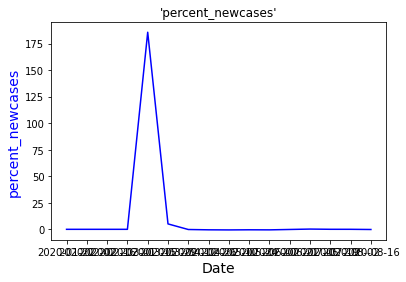

In [777]:
fig,ax = plt.subplots()
# make a plot
ax.plot(albany_county.startDate, albany_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(albany_county.startDate, albany_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [778]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [779]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

## Determining growth label

In [780]:
new_cases_list = average_newCases_df2['percent_newcases'].values
diffArr = np.diff(new_cases_list)
print(len(diffArr))
diffArr[0]

927


0.0

In [781]:
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA

print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

growth_values :  1
growth_values :  928


In [782]:
average_newCases_df2['growth_per_day'] = growth_values


### Checking mean, std dev and variance for growth data


In [783]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -410.1818181818182
max  410.1818181818182
mean  -0.00032362459546908474
std. deviation  32.09455055755334
variance  1030.0601754913473


### Getting positive cases

In [784]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))


length diffArr:  927
non_zero_pos_diff length:  346


In [785]:
stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


min  0.0017954390742000743
max  410.1818181818182
mean  7.382190750051543
std. deviation  34.6036303542645
variance  1197.4112336945757


### Getting negative cases

In [786]:
print('length diffArr: ',len(diffArr))

non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))


length diffArr:  927
non_zero_neg_diff length :  321


In [787]:
stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -410.1818181818182
max  -1.8058399404691343e-16
mean  -7.958062303793877
std. deviation  39.52113875903114
variance  1561.9204088105935


### Applying Jenks Natural break

In [788]:

pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)

[0.0017954390742000743, 39.5, 410.1818181818182]
[-410.1818181818182, -143.5789473684211, -1.8058399404691343e-16]


#### **Note**: 

From the positive and negative break, 
* [ -0.0021 , 0.0017 ] - flat growth
* [ 0.0017 , 39.5 ] - mild growth
* [ 39.5 , 410.1818 ] - drastic growth
* [ -0.0021 , -39.5 ] - mild decrement
* [ -39.5, -410.18 ] - drastic decrement

In [789]:
def determine_growth_label_inertia(x):
  if x >= -0.0021 and x <= 0.0017:
    return 'flat_growth'
  if x > 0.0017 and x <= 39.5:
    return 'mild_growth'
  if x > 39.5 and x <= 410.1818:
    return 'drastic_growth'
  if x >= -39.5  and x <= -0.0021:
    return 'mild_decrement'
  if x >= -410.1818 and x < -39.5:
    return 'drastic_decrement'

In [790]:
average_newCases_df2['growth_label'] = average_newCases_df2['growth_per_day'].apply(lambda x: determine_growth_label_inertia(x) )

## Jenks Natural breaks 

In [791]:
!pip install jenkspy


In [792]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

[-1.173913043478261, 39.5, 207.76311605723367, 410.1818181818182]


### Labeling criteria

We have applied "jenks Natural breaks' to label the county data as per 'percent change in cases'

From the natural break algorithm, we have splited the data as follows 

* -1.136 to 3.642 is **label 1** (least chance of spreading) 

* 3.642 to 13.625 is **label 2** (Below threshold but chances to reach super spread level)

* 13.625 to 410.181818 is **label 3** (Super spread week)

4 class labeling

In [793]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=4)
print(breaks)

[-1.173913043478261, 39.5, 140.00000000000003, 207.76311605723367, 410.1818181818182]


In [794]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread','SuperSpread2'])

In [795]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['CTNAME'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['CTNAME'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']['CTNAME'].count())

print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['CTNAME'].count())

Number of records in LessSpread: 915
Number of records in Spread: 4
Number of records in SuperSpread: 6
Number of records in SuperSpread: 2


8 class labeling

In [796]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)

[-1.173913043478261, 3.7500000000000018, 13.625000000000002, 39.5, 105.44104803493447, 140.00000000000003, 185.66666666666666, 207.76311605723367, 410.1818181818182]


In [797]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])

In [798]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['CTNAME'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['CTNAME'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['CTNAME'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['CTNAME'].count())
print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['CTNAME'].count())
print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['CTNAME'].count())
print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['CTNAME'].count())
print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['CTNAME'].count())

Number of records in LessSpread: 867
Number of records in Spread: 41
Number of records in SuperSpread: 7
Number of records in SuperSpread2: 3
Number of records in SuperSpread3: 1
Number of records in SuperSpread4: 5
Number of records in SuperSpread5: 1
Number of records in SuperSpread6: 2


In [799]:
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels
0,Albany County,36001,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth,LessSpread
1,Allegany County,36003,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth,LessSpread
2,Broome County,36007,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth,LessSpread
3,Cattaraugus County,36009,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth,LessSpread
4,Cayuga County,36011,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,flat_growth,LessSpread


# 2.3 Labeling data for NY -S.D Inertia combined

In [800]:
NY_combined_sd_inertia_data.head(2)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,New York,36001,0,0,36001,Albany County,36,20,21,4.32,40.3,2.3,35.4,1.06,3.25,0,307117,0.4,2020-01-22,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4240,2020-01-22,New York,36043,0,0,36043,Herkimer County,36,16,20,4.29,35.2,0.4,47.9,1.04,3.25,0,61833,-0.7,2020-01-22,1.04,27,51862,1.1,2.1,49.46,43,12,106,2.74,0.22,0.029,37.0,67,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [801]:
NY_combined_sd_inertia_data_ = NY_combined_sd_inertia_data.copy()

In [802]:
NY_combined_sd_inertia_data = NY_combined_sd_inertia_data_.copy().reset_index(drop=True)

In [803]:
#average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in tqdm(average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['FIPS']
    #print(startDate,endDate,fips)
    df_index = (NY_combined_sd_inertia_data['FIPS'] == row['FIPS']) & (NY_combined_sd_inertia_data['Date'] >= startDate) & (NY_combined_sd_inertia_data['Date'] <= endDate)
    df_weekData =  NY_combined_sd_inertia_data.loc[df_index]
    #print(df_weekData)
    NY_combined_sd_inertia_data.loc[df_index,'label'] = row['labels']
    NY_combined_sd_inertia_data.loc[df_index,'growth_label'] = row['growth_label']




928it [00:06, 149.38it/s]


In [804]:
NY_combined_sd_inertia_data.head(5)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases,label,growth_label
0,2020-01-22,New York,36001,0,0,36001,Albany County,36,20,21,4.32,40.3,2.3,35.4,1.06,3.25,0,307117,0.4,2020-01-22,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
1,2020-01-22,New York,36043,0,0,36043,Herkimer County,36,16,20,4.29,35.2,0.4,47.9,1.04,3.25,0,61833,-0.7,2020-01-22,1.04,27,51862,1.1,2.1,49.46,43,12,106,2.74,0.22,0.029,37.0,67,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
2,2020-01-22,New York,36041,0,0,36041,Hamilton County,36,13,16,4.31,37.6,1.6,67.0,0.28,4.03,0,4434,7.0,2020-01-22,0.37,36,57552,0.8,1.6,51.30,3,1,249,2.74,0.22,0.029,37.0,96,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
3,2020-01-22,New York,36111,0,0,36111,Ulster County,36,17,21,4.29,29.4,1.9,45.6,0.92,3.38,0,178599,5.7,2020-01-22,2.47,26,63348,5.4,10.0,49.51,154,86,144,2.74,0.22,0.029,37.0,59,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
4,2020-01-22,New York,36039,0,0,36039,Greene County,36,15,17,4.22,38.9,2.3,53.0,0.92,3.30,0,47491,-4.0,2020-01-22,1.13,29,53617,5.8,5.8,52.30,72,24,135,2.74,0.22,0.029,37.0,78,0.0,0.8,3.7,4.2,0.7,63.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth


In [805]:
NY_combined_sd_inertia_data[NY_combined_sd_inertia_data['label'] == 'SuperSpread2'].sort_values(by=['FIPS','Date']).count()

Date                                          42
Province_State                                42
FIPS                                          42
New cases                                     42
mask_rule_active                              42
CTFIPS                                        42
CTNAME                                        42
STFIPS                                        42
Social distancing index                       42
% staying home                                42
Trips/person                                  42
% out-of-county trips                         42
% out-of-state trips                          42
Miles/person                                  42
Work trips/person                             42
Non-work trips/person                         42
New COVID cases                               42
Population                                    42
% change in consumption                       42
date                                          42
Transit mode share  

In [806]:
NY_combined_sd_inertia_data.shape

(12296, 56)

In [807]:
NY_combined_sd_inertia_data['label'] = NY_combined_sd_inertia_data['label'].apply(lambda x: x if x != 'SuperSpread2' else 'SuperSpread')




## Determining growth label per 1k population

In [834]:
newcases_1k_inertia = NY_combined_sd_inertia_data['New cases/1000 people'].values

In [835]:
diffArr = np.diff(newcases_1k_inertia)
print(len(diffArr))
diffArr[0]

growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

12295
growth_values :  1
growth_values :  12296


## Determining mean,stddev, variance

In [836]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)



min  -3.4435000000000002
max  3.4561
mean  -2.0317216798752356e-19
std. deviation  0.24274136957731376
variance  0.05892337250427003


## Getting positive cases

In [837]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))


stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


length diffArr:  12295
non_zero_pos_diff length:  4555
min  9.99999999999994e-05
max  3.4561
mean  0.0893727552140505
std. deviation  0.2672399123540071
variance  0.07141717075497742


# Getting negative cases

In [838]:
non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))

stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


non_zero_neg_diff length :  4531
min  -3.4435000000000002
max  -9.999999999999593e-05
mean  -0.08984614875303466
std. deviation  0.2683145480804348
variance  0.07199269671160796


## Applying natural breaks

In [839]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)


[9.99999999999994e-05, 0.7438999999999999, 3.4561]
[-3.4435000000000002, -0.7543000000000001, -9.999999999999593e-05]


## Determine growth label/1k population

In [840]:
def determine_growth_label_inertia1k(x):
  if x >= -0.00009 and x <= 0.00009:
    return 'flat_growth'
  if x > 0.00009 and x <= 0.7438:
    return 'mild_growth'
  if x > 0.7438 and x <= 3.4561:
    return 'drastic_growth'
  if x >= -0.7543  and x <= -0.00009:
    return 'mild_decrement'
  if x >= -3.4435 and x < -0.7543:
    return 'drastic_decrement'


In [841]:
NY_combined_sd_inertia_data['growth_label_1k'] = NY_combined_sd_inertia_data['New cases/1000 people'].apply(lambda x: determine_growth_label_inertia1k(x) )

In [842]:
NY_combined_sd_inertia_data.to_csv('NY_sd_inertia_labeledData_Sep24.csv',index=False)

In [809]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels


## Kernal Density Estimation

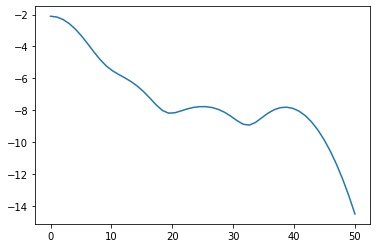

In [810]:
%matplotlib inline

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = array(data).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [811]:


from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

Minima: [19.3877551  32.65306122]
Maxima: [24.48979592 38.7755102 ]


In [812]:
lower_range = s[mi][0]
upper_range = s[mi][1]

lower_range

19.387755102040817

In [813]:
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

[-1.1363636363636362, 39.5, 213.91325695581014, 410.1818181818182]

Minima: [19.3877551  33.67346939]
Maxima: [24.48979592 39.79591837]*italicized text*

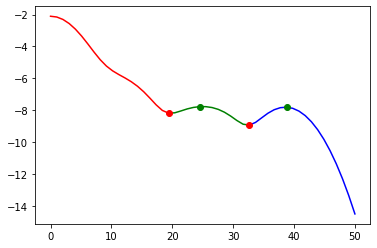

In [814]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


## Labeling Data with Kernal density results

In [815]:
average_newCases_df3.head()

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
0,Albany County,36001,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0
1,Allegany County,36003,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0
2,Broome County,36007,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0
3,Cattaraugus County,36009,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0
4,Cayuga County,36011,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0


In [816]:
print(lower_range, upper_range)

19.387755102040817 32.6530612244898


In [817]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range  else 'SuperSpread')


In [818]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range else ('Spread' if (x >= lower_range and x <= upper_range) else 'SuperSpread'))



#converter = lambda x : x*2 if x < 10 else (x*3 if x < 20 else x)



In [819]:
average_newCases_df3[average_newCases_df3['label'] == 'lessSpread'].count()

CTNAME              909
FIPS                909
average_per_week    909
startDate           909
endDate             909
diff_avg_x          909
shift_avg_x         851
percent_newcases    909
label               909
dtype: int64

In [820]:
average_newCases_df3[average_newCases_df3['label'] == 'Spread'].count()

CTNAME              4
FIPS                4
average_per_week    4
startDate           4
endDate             4
diff_avg_x          4
shift_avg_x         4
percent_newcases    4
label               4
dtype: int64

In [821]:
average_newCases_df3[average_newCases_df3['label'] == 'SuperSpread'].count()

CTNAME              15
FIPS                15
average_per_week    15
startDate           15
endDate             15
diff_avg_x          15
shift_avg_x         15
percent_newcases    15
label               15
dtype: int64

In [823]:
average_newCases_df3[average_newCases_df3['growth_label'] == 'mild_decrement'].count()

KeyError: ignored

In [ ]:
average_newCases_df3.head()

# unused code


In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] != 'Queens County']

In [ ]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

In [ ]:
week_df.head()

In [ ]:
NY_combined_data.dtypes

In [ ]:
start_date_df = (
    NY_combined_data
    .merge(week_df, left_on=['Date'],right_on=['startDate'], how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"starting_rolling_avg_new_cases": "rolling_avg_new_cases"})
    .reset_index(drop=True)

    [['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','startDate','WeekNumber','rolling_avg_new_cases']]
    .pivot_table(values='rolling_avg_new_cases', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

start_date_df

In [ ]:
end_date_df = (
    NY_combined_data
    .merge(week_df, on='Date', how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"Confirmed": "end_date_Confirmed"})
    .reset_index(drop=True)

    [['County Name', 'fips_x', 'end_date_Confirmed','endDate','WeekNumber']]
    .pivot_table(values='end_date_Confirmed', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)